In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F

if torch.cuda.is_available():  
    dev = torch.device("cuda:0")
else:
    dev = torch.device("cpu")
#dev = torch.device("cpu")
print(f"Using {dev}")

Using cuda:0


C:\Users\morga\anaconda3\lib\site-packages\PiecewiseLinearSegmentation\bottomup.py:27: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ( p, residuals, rank, s ) = lstsq( X, y )


MAX LENGTH:217


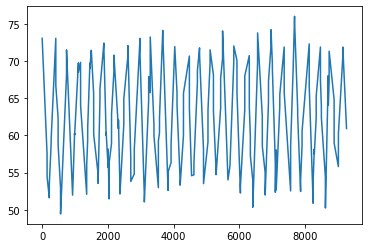

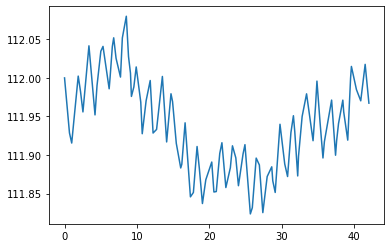

In [2]:
# ---- data loading and pre-processing ---- #

import utils.polar_pla as pla
import numpy as np
import torch
from torch.autograd import Variable

torch.set_default_tensor_type('torch.cuda.FloatTensor')
# read in time series into temporary list
temp = []
f = open('DataSets/CTtemp.csv', 'r')
for line in f:
    temp.append(float(line))

# run bottom up piecewise linear approximation on that list and store processed values
data, max_len = pla.bottom_up_pla(temp,1000)
pla.display_trends(data, 112)
#print(data)
# set the sequence length (the number of trends we look at to predict the next) and the train to test ratio
seq_length = 2
train_proportion = 0.8

# segment the data into input output pairs that we will use to train the model
def sliding_window(data):
    inputs = []
    outputs = []
    for i in range(0, len(data)-seq_length*2, 2):
        inputs.append(data[i:(i+seq_length*2)]) # the next n are the input
        outputs.append(data[i+seq_length*2+1:i+seq_length*2+2]) # and the one after that is the output
    return Variable(torch.cuda.FloatTensor(np.array(inputs)).to(dev)), Variable(torch.cuda.FloatTensor(np.array(outputs)).to(dev))
    
# convert data to tensor, and apply dataloader
total_data_input, total_data_output = sliding_window(data)
train_size = int(len(total_data_input)*train_proportion)

training_data_input = torch.narrow(total_data_input, 0, 0, train_size).to(dev)
training_data_output = torch.narrow(total_data_output, 0, 0, train_size).to(dev)

testing_data_input = torch.narrow(total_data_input, 0, train_size, len(total_data_input) - train_size).to(dev)
testing_data_output = torch.narrow(total_data_output, 0, train_size, len(total_data_input) - train_size).to(dev)

train = torch.utils.data.TensorDataset(training_data_input, training_data_output)
test = torch.utils.data.TensorDataset(testing_data_input, testing_data_output)
trainset = torch.utils.data.DataLoader(train, batch_size=128, shuffle=False)
testset = torch.utils.data.DataLoader(test, batch_size=128, shuffle=False)

In [3]:
from models import MLP
net = MLP(seq_length*2, 64, 0.0)
print(net)

MLP(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (do): Dropout(p=0.0, inplace=False)
)


Epoch: 0/5000, loss: 0.3338637053966522
Epoch: 500/5000, loss: 0.06274425238370895
Epoch: 1000/5000, loss: 0.06487266719341278
Epoch: 1500/5000, loss: 0.0680088996887207
Epoch: 2000/5000, loss: 0.0691949799656868
Epoch: 2500/5000, loss: 0.07356099784374237
Epoch: 3000/5000, loss: 0.08090697228908539
Epoch: 3500/5000, loss: 0.09234593063592911
Epoch: 4000/5000, loss: 0.09509560465812683
Epoch: 4500/5000, loss: 0.09470970183610916
Epoch: 5000/5000, loss: 0.09475528448820114


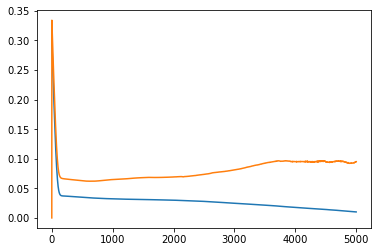

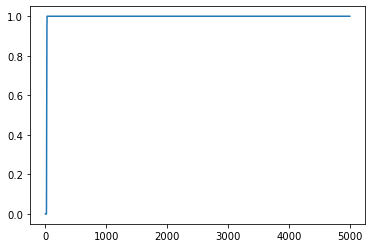

Lowest validation loss: 0.062004704028367996 at epoch 613


In [4]:
# training

epochs = 5000

import torch.optim as optim
train_loss = []
validation_loss = []
net.train()
epoch_total_trainloss = 0 # the total loss for each epoch, used for plotting
min_val_loss_epoch = 0 # the epoch with the lowest validation loss
min_val_loss = 1000000 # the lowest validation loss
optimizer = optim.Adam(net.parameters(), lr=0.0001)
train_direction_accuracy = []
validation_direction_accuracy = []
for epoch in range(epochs+1):

    validation_loss.append(epoch_total_trainloss) # we'll need to plot validation loss too
    epoch_total_trainloss = 0 # reset this for the validation epoch'''
    net.train()
    for data in trainset:  # for each batch
        features, labels = data  # split the batches up into their features and labels
        net.zero_grad()
        output = net(features.view(-1,seq_length*2)) # get a prediction from the model
        output = output
        #print(output.shape)
        loss = F.mse_loss(output, labels)  # calculate the loss of our prediction
        loss.backward()  # backpropogate the loss
        optimizer.step()  # optimize weights
        epoch_total_trainloss += loss.item()/len(trainset)  # sum the losses of this epoch
        torch.cuda.synchronize()
    
    train_loss.append(epoch_total_trainloss) # add this epoch's loss in order to plot it later
    epoch_total_trainloss = 0 # reset this for the validation epoch
    if epoch %(epochs/10) == 0: print(f"Epoch: {epoch}/{epochs}, loss: {loss.item()}")
    # now we'll calculate the direction accuracy for the training and validation sets
    correct=0
    net.eval()
    for data in testset:
        
        inputs, labels = data
        output = net(inputs.view(-1,seq_length*2))
        for i in range(len(output)):
            pred = output[i]
            actual = labels[i]
            if pred < 0 and actual < 0 or pred > 0 and actual > 0:
                correct += 1
            #print(output[0],labels[0])
        loss = F.mse_loss(output, labels)  # calculate the loss of our prediction
        epoch_total_trainloss += loss.item()/len(testset)
        torch.cuda.synchronize()
    
    if epoch_total_trainloss < min_val_loss:
        min_val_loss = epoch_total_trainloss
        min_val_loss_epoch = epoch
    validation_direction_accuracy.append(correct/len(test))

import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.plot(validation_loss)
plt.show()
plt.plot(validation_direction_accuracy)
plt.show()
print(f"Lowest validation loss: {min_val_loss} at epoch {min_val_loss_epoch}")

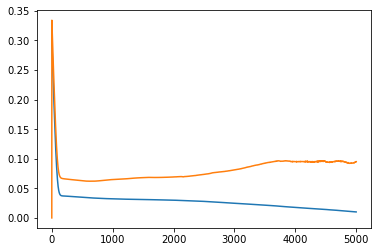

Directional Accuracy: 100.0, Average Loss: 0.09475528747210965


In [5]:
# test
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.plot(validation_loss)
plt.show()

with torch.no_grad():
    correct = 0
    i = 0
    X, Y = [], []
    X2, Y2 = [], []
    total_loss = 0
    output_file = open("lengths.txt", "w")
    for data in train:
        inputs, labels = data
        output = net(inputs.view(-1,seq_length*2))
        output_file.write(str(output.item()*max_len) + "\n")
        net.zero_grad()

    for data in test:
        inputs, labels = data
        output = net(inputs.view(-1,seq_length*2))
        output_file.write(str(output.item()*max_len) + "\n")
        net.zero_grad()
        total_loss += F.mse_loss(output[0], labels).item()
        output = output[0]
        if output[0] < 0 and labels[0] < 0 or output[0] > 0 and labels[0] > 0:
            correct += 1
            #print(output[0],labels[0])
    print(f'Directional Accuracy: {correct*100/len(test)}, Average Loss: {total_loss/len(test)}')


